<a href="https://colab.research.google.com/github/ChrizZhuang/memtransistor_NLP/blob/main/RNN_4_terminals_memtransistor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RNN Simulation of Dual gates 4 terminals memtransistor**

**Hardware paper**

- *Dual-Gated MoS2 Memtransistor Crossbar Array* https://onlinelibrary.wiley.com/doi/abs/10.1002/adfm.202003683

**Hardware code with the application of CV**

- https://colab.research.google.com/drive/1_zY4qp1u8IZhc_ht4t-iHr2m53j7u2li

**RNN Algorithm for sentiment analysis**

- https://www.tensorflow.org/text/tutorials/text_classification_rnn

### **Import modules**

In [1]:
# uses tensorflow v2.7.0
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

tfds.disable_progress_bar()
print(tf.__version__)

2.7.0


In [2]:
# mount to google drive to save model and weights
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Utils**


In [3]:
# imports data from single column CSV file with possible current/conductance states
# return numpy array of approximate states possible using this hardware
# this import method is not generalized, but fine-tuned to Vinod's devices
def import_data_from_csv(filename):
  # import data
  imported_device_states = np.genfromtxt(filename, delimiter=',')[1:]

  # since data is in ~1 nA, assume maximum precision is ~1 pA
  # this will make some states redundant
  imported_device_states = np.unique(np.round(np.sort(imported_device_states), decimals=3))

  # calculate device states possible
  device_states = np.array([])
  for i, value in enumerate(imported_device_states):
      if i+1 > len(imported_device_states):
          break
      temp_ls = value - imported_device_states
      device_states = np.append(device_states, temp_ls)


  # normalize to -1 to 1
  device_states = np.unique(np.sort(device_states))
  device_states = device_states / np.abs(device_states).max()

  # given the large number of states, we can assume some states are almost equivalent
  # moreover, once the number of states is > 100, the discreteness doesnt matter
  # for simplicity in the simulations, we will simply  round to 2 digits of the calculated states
  device_states = np.round(device_states, decimals = 2)
  device_states = np.unique(np.sort(device_states))
  
  return device_states

In [4]:
def plot_figure(train_accuracy, test_accuracy):
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(len(train_accuracy)), train_accuracy, label = 'train')
  plt.plot(np.arange(len(test_accuracy)), test_accuracy, label = 'test')
  plt.legend(fontsize=15)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel("epoch", fontsize=15)
  plt.ylabel("accuracy", fontsize=15)
  plt.show()

###**Construct the final function**

In [5]:
def run_RNN_simulation(save_results_input=False,
            num_epochs_input=50, 
            hardware_simulation_input=False, 
            device_states_input=False,
            read_noise_mean_input=0,
            read_noise_stddev_input=0,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True):
  
  ###################### USER DEFINED PARAMETERS FOR SIMULATION
  # whether or not to save results
  SAVE_RESULTS = save_results_input
  
  # number of epochs to test
  NUM_EPOCHS = num_epochs_input

  # flag which determines whether this is a hardware simulation or purely software
  HARDWARE_SIMULATION = hardware_simulation_input

  # parameter set by user that gives all the possible normalized weight states
  DEVICE_STATES = device_states_input

  # parameters for simulating read noise
  # user input = read noise mean and standard dev assuming a normal noise function
  READ_NOISE_MEAN = read_noise_mean_input
  READ_NOISE_STDDEV = read_noise_stddev_input

  # parameter for simulating device-to-device variation
  # user input =  standard deviation of conductances
  DEVICE_VARIATION_STDDEV = device_variation_stddev_input

  # parameter for simulating devices that get stuck on Gmax or Gmin states from the start
  # user input = probability for a device to get stuck
  DEVICE_STUCK_ON_PROB = device_stuck_on_prob_input
  DEVICE_STUCK_OFF_PROB = device_stuck_off_prob_input

  # for RNN model and training
  BUFFER_SIZE = 10000
  BATCH_SIZE = 32

  # load data
  dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
  train_dataset, test_dataset = dataset['train'], dataset['test']

  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  VOCAB_SIZE = 1000
  # Maximum size of the vocabulary for this layer. 
  # This should only be specified when adapting a vocabulary or when setting pad_to_max_tokens=True. 
  encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, name = 'encoder')
  # adapt: Fits the state of the preprocessing layer to the data being passed.
  encoder.adapt(train_dataset.map(lambda text, label: text))

  vocab = np.array(encoder.get_vocabulary()) 

  model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        name='embedding',
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(32, name='lstm'),
    tf.keras.layers.Dense(32, activation='relu', name='dense1'),
    tf.keras.layers.Dense(1, name='dense2')
  ])

  plot_time = time.time()
  plot_dir = '/content/drive/MyDrive/RNN_model_plot/'+str(plot_time)+'model.png'
  tf.keras.utils.plot_model(model, to_file=plot_dir, show_shapes=True, show_layer_names=True)

  # 1. keras.layers.preprocessing.index_lookup.VocabWeightHandler - not trainable
  # 2. 'embedding/embeddings:0' shape=(1000, 32)
  # 3. 'lstm/lstm_cell/kernel:0' shape=(32, 256)
  # 4. 'lstm/lstm_cell/recurrent_kernel:0' shape=(32, 256)
  # 5. 'lstm/lstm_cell/bias:0' shape=(256,)
  # 6. 'dense/kernel:0' shape=(32, 32)
  # 7. 'dense/bias:0' shape=(32,)
  # 8. 'dense_1/kernel:0' shape=(32, 1)
  # 9. 'dense_1/bias:0' shape=(1,)
  model_weights = model.trainable_variables # len(weights) = 8

  g_min_value = np.min(np.abs(DEVICE_STATES))
  g_max_value = np.max(np.abs(DEVICE_STATES))
      
  # to make this notebook's output stable across runs
  def reset_graph(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

  # create matrix to simulate device-to-device variation by creating clipping the weights
  # and simulate devices being stuck-on-open and stuck-on-close 
  def initialize_variation_stuck_mat(shape):
    # VARIATION
    wp_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
    wp_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

    wm_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
    wm_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

    # STUCK
    stuck_prob = [DEVICE_STUCK_OFF_PROB, 1 - DEVICE_STUCK_ON_PROB - DEVICE_STUCK_OFF_PROB, DEVICE_STUCK_ON_PROB]
    w_p_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob) 
    w_m_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob)

    # if device is stuck OFF
    wp_max = wp_max + (w_p_stuck == -1) * (wp_min - wp_max)
    wm_max = wm_max + (w_m_stuck == -1) * (wm_min - wm_max)

    # if device is stuck ON
    wp_min = wp_min + (w_p_stuck == 1) * (wp_max - wp_min)
    wm_min = wm_min + (w_m_stuck == 1) * (wm_max - wm_min)


    # PUTTING TOGETHER CLIPPING MATRIX
    # numpy.clip(a, a_min, a_max) 
    # Clip (limit) the values in an array.
    # Given an interval, values outside the interval are clipped to the interval edges
    lower_lim = np.clip(wp_min - wm_max, -g_max_value, -g_min_value)
    upper_lim = np.clip(wp_max - wm_min, g_min_value, g_max_value)

    #print('Lower lim: ' + str(lower_lim))
    #print('Upper lim: ' + str(upper_lim))

    return [lower_lim, upper_lim]

  # weight update with a discrete number of states and (optional) add read noise
  def discrete_weight_update(value, read_noise_mean=0, read_noise_stddev=0):
      if read_noise_stddev != 0:
          value += np.random.normal(read_noise_mean, read_noise_stddev)
      absolute_difference_function = lambda list_value : abs(list_value - value)
      return min(DEVICE_STATES, key=absolute_difference_function)
  v_discrete_weight_update = np.vectorize(discrete_weight_update)

  # function puts together all the parts
  # 1. Device variation
  # 2. Stuck-on/off 
  # 3. Discrete number of weight states
  # Input = software weights matrix, Output = hardware weights matrix
  def simulate_hardware_weight_update(weights_mat, var_stuck_mat):

    # initialize variation and stuck matrix if not initialized
    if type(weights_mat) is not np.array:
      weights_mat = np.array(weights_mat)

    if type(var_stuck_mat) is not np.ndarray:
        var_stuck_mat = initialize_variation_stuck_mat(weights_mat.shape)

    # simulate weight variation and stuck on open/close
    weights_mat = weights_mat.clip(var_stuck_mat[0], var_stuck_mat[1])

    # simulate discrete states
    weights_mat = v_discrete_weight_update(weights_mat, read_noise_mean = READ_NOISE_MEAN,
                          read_noise_stddev = READ_NOISE_STDDEV)

    return weights_mat

  # reset default tf graph before running sim
  reset_graph()

  # define weight update ops
  var_stuck_mat = [False, False, False, False, False, False, False, False]
  weights = np.zeros([1, 8])[0].tolist()
  new_weights = np.zeros([1, 8])[0].tolist()
  weight_update_op = np.zeros([1, 8])[0].tolist()
  weight_layers = ["embedding/embeddings:0", "lstm/lstm_cell/kernel:0", "lstm/lstm_cell/recurrent_kernel:0", "lstm/lstm_cell/bias:0",
            "dense1/kernel:0", "dense1/bias:0", "dense2/kernel:0", "dense2/bias:0"]

  train_accuracy_ls = []
  train_loss_ls = []

  test_accuracy_ls = []
  test_loss_ls = []

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

  # train the model weights
  for i in range(NUM_EPOCHS):
    # mark the time
    start_time = time.time()
    start_datetime  = datetime.utcnow().strftime("%Y%m%d%H%M%S")

    print("Training the "+str(i+1)+"th epoch!")

    history = model.fit(train_dataset, epochs=1,
            validation_data=test_dataset,
            validation_steps=30)
    
    train_accuracy_ls.append(history.history['accuracy'][0])
    train_loss_ls.append(history.history['loss'][0])
    test_accuracy_ls.append(history.history['val_accuracy'][0])
    test_loss_ls.append(history.history['val_loss'][0])

    if HARDWARE_SIMULATION:

      # obtain the original weights
      weights = model.trainable_variables

      # update the weights cosidering the hardware
      new_weights = []
      for i, weight in enumerate(weights):
        new_weights.append(simulate_hardware_weight_update(weight, var_stuck_mat[i]))

      model.layers[1].set_weights([new_weights[0]])
      model.layers[2].set_weights([new_weights[1], new_weights[2], new_weights[3]])
      model.layers[3].set_weights([new_weights[4], new_weights[5]])
      model.layers[4].set_weights([new_weights[6], new_weights[7]])

    # save the results for current epoch
    if SAVE_RESULTS:
      file_name = 'model_' + str(start_datetime) + '_' + str(NUM_EPOCHS)
      model.save('/content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/'+file_name)
      print("Save results in file "+file_name+" successfully!\n")

  # save the final result
  if SAVE_RESULTS:
    file_name = 'final_model_' + '_' + str(NUM_EPOCHS)
    model.save('/content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/'+file_name)
    print("Save results in file "+file_name+" successfully!\n")

  if plot_fig:
    plot_figure(train_accuracy_ls, test_accuracy_ls)

  return model, train_accuracy_ls, test_accuracy_ls

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBHUSZ7/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBHUSZ7/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBHUSZ7/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training the 1th epoch!
782/782 [==============================] - 102s 120ms/step - loss: 0.6376 - accuracy: 0.5677 - val_loss: 0.5221 - val_accuracy: 0.6865


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202215_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202215_30/assets


Save results in file model_20220212202215_30 successfully!

Training the 2th epoch!
782/782 [==============================] - 93s 118ms/step - loss: 0.5265 - accuracy: 0.7284 - val_loss: 0.4747 - val_accuracy: 0.7979


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202459_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202459_30/assets


Save results in file model_20220212202459_30 successfully!

Training the 3th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.5231 - accuracy: 0.7407 - val_loss: 0.4703 - val_accuracy: 0.7792


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202739_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202739_30/assets


Save results in file model_20220212202739_30 successfully!

Training the 4th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.5139 - accuracy: 0.7320 - val_loss: 0.4852 - val_accuracy: 0.7677


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202928_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212202928_30/assets


Save results in file model_20220212202928_30 successfully!

Training the 5th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.6877 - accuracy: 0.5532 - val_loss: 0.6182 - val_accuracy: 0.6729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203207_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203207_30/assets


Save results in file model_20220212203207_30 successfully!

Training the 6th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.5399 - accuracy: 0.7272 - val_loss: 0.5434 - val_accuracy: 0.7635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203357_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203357_30/assets


Save results in file model_20220212203357_30 successfully!

Training the 7th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.5549 - accuracy: 0.7012 - val_loss: 0.5171 - val_accuracy: 0.7448


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203546_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203546_30/assets


Save results in file model_20220212203546_30 successfully!

Training the 8th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.5500 - accuracy: 0.7189 - val_loss: 0.5435 - val_accuracy: 0.7323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203736_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203736_30/assets


Save results in file model_20220212203736_30 successfully!

Training the 9th epoch!
782/782 [==============================] - 93s 119ms/step - loss: 0.5742 - accuracy: 0.7010 - val_loss: 0.5560 - val_accuracy: 0.7302


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203941_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212203941_30/assets


Save results in file model_20220212203941_30 successfully!

Training the 10th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.5960 - accuracy: 0.6574 - val_loss: 0.5961 - val_accuracy: 0.6917


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204131_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204131_30/assets


Save results in file model_20220212204131_30 successfully!

Training the 11th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6602 - accuracy: 0.5615 - val_loss: 0.6475 - val_accuracy: 0.5823


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204410_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204410_30/assets


Save results in file model_20220212204410_30 successfully!

Training the 12th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6424 - accuracy: 0.5903 - val_loss: 0.6412 - val_accuracy: 0.5844


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204650_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204650_30/assets


Save results in file model_20220212204650_30 successfully!

Training the 13th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6404 - accuracy: 0.5964 - val_loss: 0.6358 - val_accuracy: 0.6198


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204929_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212204929_30/assets


Save results in file model_20220212204929_30 successfully!

Training the 14th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6496 - accuracy: 0.6178 - val_loss: 0.6609 - val_accuracy: 0.5833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205208_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205208_30/assets


Save results in file model_20220212205208_30 successfully!

Training the 15th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6472 - accuracy: 0.6095 - val_loss: 0.6386 - val_accuracy: 0.6031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205447_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205447_30/assets


Save results in file model_20220212205447_30 successfully!

Training the 16th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.6823 - accuracy: 0.5848 - val_loss: 0.6753 - val_accuracy: 0.5875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205635_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205635_30/assets


Save results in file model_20220212205635_30 successfully!

Training the 17th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6739 - accuracy: 0.5747 - val_loss: 0.6799 - val_accuracy: 0.5865


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205824_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212205824_30/assets


Save results in file model_20220212205824_30 successfully!

Training the 18th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.6804 - accuracy: 0.5714 - val_loss: 0.6751 - val_accuracy: 0.5760


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210012_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210012_30/assets


Save results in file model_20220212210012_30 successfully!

Training the 19th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6815 - accuracy: 0.5572 - val_loss: 0.6863 - val_accuracy: 0.5552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210251_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210251_30/assets


Save results in file model_20220212210251_30 successfully!

Training the 20th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.6953 - accuracy: 0.5526 - val_loss: 0.6858 - val_accuracy: 0.5521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210439_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210439_30/assets


Save results in file model_20220212210439_30 successfully!

Training the 21th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6748 - accuracy: 0.5701 - val_loss: 0.6791 - val_accuracy: 0.5896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210718_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210718_30/assets


Save results in file model_20220212210718_30 successfully!

Training the 22th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.6776 - accuracy: 0.5898 - val_loss: 0.6648 - val_accuracy: 0.5990


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210905_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212210905_30/assets


Save results in file model_20220212210905_30 successfully!

Training the 23th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.6404 - accuracy: 0.6207 - val_loss: 0.6503 - val_accuracy: 0.6240


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211054_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211054_30/assets


Save results in file model_20220212211054_30 successfully!

Training the 24th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.6340 - accuracy: 0.6427 - val_loss: 0.6362 - val_accuracy: 0.6594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211333_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211333_30/assets


Save results in file model_20220212211333_30 successfully!

Training the 25th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.6246 - accuracy: 0.6491 - val_loss: 0.6142 - val_accuracy: 0.6760


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211612_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211612_30/assets


Save results in file model_20220212211612_30 successfully!

Training the 26th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.6496 - accuracy: 0.6364 - val_loss: 0.6309 - val_accuracy: 0.6417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211852_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212211852_30/assets


Save results in file model_20220212211852_30 successfully!

Training the 27th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.6236 - accuracy: 0.6566 - val_loss: 0.6381 - val_accuracy: 0.6500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212041_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212041_30/assets


Save results in file model_20220212212041_30 successfully!

Training the 28th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.6402 - accuracy: 0.6272 - val_loss: 0.6406 - val_accuracy: 0.6323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212320_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212320_30/assets


Save results in file model_20220212212320_30 successfully!

Training the 29th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.6253 - accuracy: 0.6448 - val_loss: 0.6544 - val_accuracy: 0.6229


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212559_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212559_30/assets


Save results in file model_20220212212559_30 successfully!

Training the 30th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.6458 - accuracy: 0.6206 - val_loss: 0.6640 - val_accuracy: 0.6187


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212839_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212212839_30/assets


Save results in file model_20220212212839_30 successfully!



INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


Save results in file final_model__30 successfully!



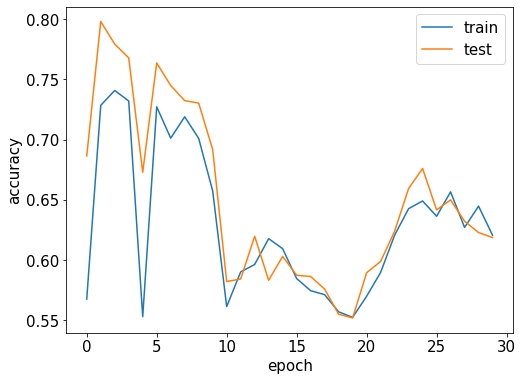

In [6]:
# for the 1st learning curve from vinod
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_1.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

Training the 1th epoch!
782/782 [==============================] - 99s 120ms/step - loss: 0.6635 - accuracy: 0.5230 - val_loss: 0.5920 - val_accuracy: 0.5188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213138_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213138_30/assets


Save results in file model_20220212213138_30 successfully!

Training the 2th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.4351 - accuracy: 0.7942 - val_loss: 0.4074 - val_accuracy: 0.8219


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213417_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213417_30/assets


Save results in file model_20220212213417_30 successfully!

Training the 3th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.3529 - accuracy: 0.8490 - val_loss: 0.3732 - val_accuracy: 0.8281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213652_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213652_30/assets


Save results in file model_20220212213652_30 successfully!

Training the 4th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3277 - accuracy: 0.8624 - val_loss: 0.3495 - val_accuracy: 0.8479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213836_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212213836_30/assets


Save results in file model_20220212213836_30 successfully!

Training the 5th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3169 - accuracy: 0.8678 - val_loss: 0.3445 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214021_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214021_30/assets


Save results in file model_20220212214021_30 successfully!

Training the 6th epoch!
782/782 [==============================] - 93s 118ms/step - loss: 0.3120 - accuracy: 0.8698 - val_loss: 0.3394 - val_accuracy: 0.8531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214256_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214256_30/assets


Save results in file model_20220212214256_30 successfully!

Training the 7th epoch!
782/782 [==============================] - 93s 118ms/step - loss: 0.3080 - accuracy: 0.8710 - val_loss: 0.3591 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214531_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214531_30/assets


Save results in file model_20220212214531_30 successfully!

Training the 8th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3070 - accuracy: 0.8712 - val_loss: 0.3441 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214716_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214716_30/assets


Save results in file model_20220212214716_30 successfully!

Training the 9th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3044 - accuracy: 0.8731 - val_loss: 0.3347 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214901_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212214901_30/assets


Save results in file model_20220212214901_30 successfully!

Training the 10th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.3020 - accuracy: 0.8742 - val_loss: 0.3417 - val_accuracy: 0.8615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215046_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215046_30/assets


Save results in file model_20220212215046_30 successfully!

Training the 11th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.3019 - accuracy: 0.8742 - val_loss: 0.3353 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215230_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215230_30/assets


Save results in file model_20220212215230_30 successfully!

Training the 12th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.3013 - accuracy: 0.8734 - val_loss: 0.3447 - val_accuracy: 0.8635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215414_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215414_30/assets


Save results in file model_20220212215414_30 successfully!

Training the 13th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2991 - accuracy: 0.8755 - val_loss: 0.3366 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215558_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215558_30/assets


Save results in file model_20220212215558_30 successfully!

Training the 14th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.2984 - accuracy: 0.8739 - val_loss: 0.3348 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215742_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215742_30/assets


Save results in file model_20220212215742_30 successfully!

Training the 15th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.2964 - accuracy: 0.8758 - val_loss: 0.3339 - val_accuracy: 0.8531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215927_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212215927_30/assets


Save results in file model_20220212215927_30 successfully!

Training the 16th epoch!
782/782 [==============================] - 92s 116ms/step - loss: 0.2958 - accuracy: 0.8772 - val_loss: 0.3337 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220111_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220111_30/assets


Save results in file model_20220212220111_30 successfully!

Training the 17th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2946 - accuracy: 0.8768 - val_loss: 0.3328 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220255_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220255_30/assets


Save results in file model_20220212220255_30 successfully!

Training the 18th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2934 - accuracy: 0.8771 - val_loss: 0.3353 - val_accuracy: 0.8656


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220439_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220439_30/assets


Save results in file model_20220212220439_30 successfully!

Training the 19th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2890 - accuracy: 0.8795 - val_loss: 0.3289 - val_accuracy: 0.8615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220622_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220622_30/assets


Save results in file model_20220212220622_30 successfully!

Training the 20th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2897 - accuracy: 0.8791 - val_loss: 0.3291 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220806_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220806_30/assets


Save results in file model_20220212220806_30 successfully!

Training the 21th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2876 - accuracy: 0.8792 - val_loss: 0.3385 - val_accuracy: 0.8698


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220949_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212220949_30/assets


Save results in file model_20220212220949_30 successfully!

Training the 22th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2842 - accuracy: 0.8829 - val_loss: 0.3347 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221132_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221132_30/assets


Save results in file model_20220212221132_30 successfully!

Training the 23th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2819 - accuracy: 0.8816 - val_loss: 0.3319 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221407_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221407_30/assets


Save results in file model_20220212221407_30 successfully!

Training the 24th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2806 - accuracy: 0.8820 - val_loss: 0.3430 - val_accuracy: 0.8656


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221550_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221550_30/assets


Save results in file model_20220212221550_30 successfully!

Training the 25th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2777 - accuracy: 0.8843 - val_loss: 0.3286 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221733_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221733_30/assets


Save results in file model_20220212221733_30 successfully!

Training the 26th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2777 - accuracy: 0.8844 - val_loss: 0.3437 - val_accuracy: 0.8635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221915_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212221915_30/assets


Save results in file model_20220212221915_30 successfully!

Training the 27th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.2753 - accuracy: 0.8852 - val_loss: 0.3429 - val_accuracy: 0.8490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222058_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222058_30/assets


Save results in file model_20220212222058_30 successfully!

Training the 28th epoch!
782/782 [==============================] - 89s 113ms/step - loss: 0.2723 - accuracy: 0.8880 - val_loss: 0.3519 - val_accuracy: 0.8646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222332_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222332_30/assets


Save results in file model_20220212222332_30 successfully!

Training the 29th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.2718 - accuracy: 0.8875 - val_loss: 0.3485 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222606_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222606_30/assets


Save results in file model_20220212222606_30 successfully!

Training the 30th epoch!
782/782 [==============================] - 89s 114ms/step - loss: 0.2696 - accuracy: 0.8880 - val_loss: 0.3551 - val_accuracy: 0.8427


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222840_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212222840_30/assets


Save results in file model_20220212222840_30 successfully!



INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


Save results in file final_model__30 successfully!



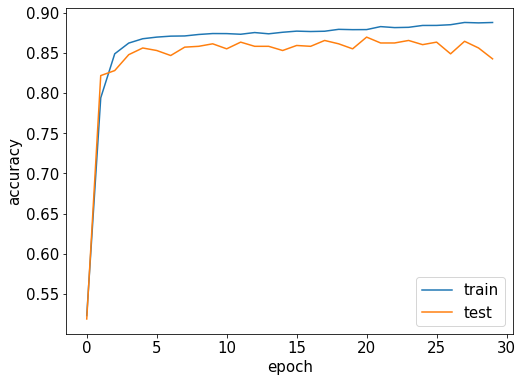

In [7]:
# pure algorithm
model, train_accuracy_ls, test_accuracy_ls = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=False, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_2.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

Training the 1th epoch!
782/782 [==============================] - 96s 116ms/step - loss: 0.6463 - accuracy: 0.5532 - val_loss: 0.5226 - val_accuracy: 0.6792


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223134_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223134_30/assets


Save results in file model_20220212223134_30 successfully!

Training the 2th epoch!
782/782 [==============================] - 89s 112ms/step - loss: 0.5907 - accuracy: 0.6590 - val_loss: 0.4874 - val_accuracy: 0.7688


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223326_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223326_30/assets


Save results in file model_20220212223326_30 successfully!

Training the 3th epoch!
782/782 [==============================] - 89s 113ms/step - loss: 0.5908 - accuracy: 0.6538 - val_loss: 0.5669 - val_accuracy: 0.6865


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223511_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223511_30/assets


Save results in file model_20220212223511_30 successfully!

Training the 4th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6224 - accuracy: 0.6134 - val_loss: 0.5453 - val_accuracy: 0.7177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223657_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223657_30/assets


Save results in file model_20220212223657_30 successfully!

Training the 5th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.6095 - accuracy: 0.6297 - val_loss: 0.5774 - val_accuracy: 0.7260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223937_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212223937_30/assets


Save results in file model_20220212223937_30 successfully!

Training the 6th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.5560 - accuracy: 0.7050 - val_loss: 0.5371 - val_accuracy: 0.7208


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224125_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224125_30/assets


Save results in file model_20220212224125_30 successfully!

Training the 7th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.5746 - accuracy: 0.6886 - val_loss: 0.5467 - val_accuracy: 0.7406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224404_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224404_30/assets


Save results in file model_20220212224404_30 successfully!

Training the 8th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.5603 - accuracy: 0.6992 - val_loss: 0.5265 - val_accuracy: 0.7365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224552_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224552_30/assets


Save results in file model_20220212224552_30 successfully!

Training the 9th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6689 - accuracy: 0.5969 - val_loss: 0.6270 - val_accuracy: 0.6354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224739_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212224739_30/assets


Save results in file model_20220212224739_30 successfully!

Training the 10th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6281 - accuracy: 0.6180 - val_loss: 0.5902 - val_accuracy: 0.6656


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225018_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225018_30/assets


Save results in file model_20220212225018_30 successfully!

Training the 11th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6607 - accuracy: 0.5763 - val_loss: 0.6344 - val_accuracy: 0.6354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225257_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225257_30/assets


Save results in file model_20220212225257_30 successfully!

Training the 12th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6258 - accuracy: 0.6332 - val_loss: 0.6162 - val_accuracy: 0.6375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225535_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225535_30/assets


Save results in file model_20220212225535_30 successfully!

Training the 13th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6472 - accuracy: 0.6039 - val_loss: 0.6474 - val_accuracy: 0.6083


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225814_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212225814_30/assets


Save results in file model_20220212225814_30 successfully!

Training the 14th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6465 - accuracy: 0.6143 - val_loss: 0.6366 - val_accuracy: 0.6146


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230052_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230052_30/assets


Save results in file model_20220212230052_30 successfully!

Training the 15th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6210 - accuracy: 0.6468 - val_loss: 0.6127 - val_accuracy: 0.6552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230331_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230331_30/assets


Save results in file model_20220212230331_30 successfully!

Training the 16th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.6162 - accuracy: 0.6599 - val_loss: 0.5946 - val_accuracy: 0.6823


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230518_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230518_30/assets


Save results in file model_20220212230518_30 successfully!

Training the 17th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6233 - accuracy: 0.6754 - val_loss: 0.6231 - val_accuracy: 0.6531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230706_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230706_30/assets


Save results in file model_20220212230706_30 successfully!

Training the 18th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6634 - accuracy: 0.5722 - val_loss: 0.6535 - val_accuracy: 0.5833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230853_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212230853_30/assets


Save results in file model_20220212230853_30 successfully!

Training the 19th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6768 - accuracy: 0.5792 - val_loss: 0.6421 - val_accuracy: 0.6031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231040_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231040_30/assets


Save results in file model_20220212231040_30 successfully!

Training the 20th epoch!
782/782 [==============================] - 89s 113ms/step - loss: 0.6675 - accuracy: 0.5928 - val_loss: 0.6431 - val_accuracy: 0.6031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231227_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231227_30/assets


Save results in file model_20220212231227_30 successfully!

Training the 21th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6964 - accuracy: 0.5708 - val_loss: 0.6794 - val_accuracy: 0.5813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231505_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231505_30/assets


Save results in file model_20220212231505_30 successfully!

Training the 22th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6884 - accuracy: 0.5925 - val_loss: 0.6711 - val_accuracy: 0.6052


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231651_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231651_30/assets


Save results in file model_20220212231651_30 successfully!

Training the 23th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6755 - accuracy: 0.5870 - val_loss: 0.6643 - val_accuracy: 0.5885


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231837_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212231837_30/assets


Save results in file model_20220212231837_30 successfully!

Training the 24th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6643 - accuracy: 0.5843 - val_loss: 0.6681 - val_accuracy: 0.5938


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232115_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232115_30/assets


Save results in file model_20220212232115_30 successfully!

Training the 25th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.6508 - accuracy: 0.6108 - val_loss: 0.6464 - val_accuracy: 0.5979


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232354_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232354_30/assets


Save results in file model_20220212232354_30 successfully!

Training the 26th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6608 - accuracy: 0.6012 - val_loss: 0.6651 - val_accuracy: 0.5938


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232541_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232541_30/assets


Save results in file model_20220212232541_30 successfully!

Training the 27th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6774 - accuracy: 0.5694 - val_loss: 0.6685 - val_accuracy: 0.5833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232728_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232728_30/assets


Save results in file model_20220212232728_30 successfully!

Training the 28th epoch!
782/782 [==============================] - 89s 113ms/step - loss: 0.6741 - accuracy: 0.5588 - val_loss: 0.6662 - val_accuracy: 0.5750


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232915_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212232915_30/assets


Save results in file model_20220212232915_30 successfully!

Training the 29th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.6554 - accuracy: 0.5958 - val_loss: 0.6488 - val_accuracy: 0.5990


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212233153_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220212233153_30/assets


Save results in file model_20220212233153_30 successfully!

Training the 30th epoch!
251/782 [========>.....................] - ETA: 59s - loss: 0.6560 - accuracy: 0.5862

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_3.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_4.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)